In [1]:
# Import

import epics
import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import LIMIT, LENGTH, pv_make, data_load
from harmonica.window import Window
from harmonica.data import Data

import matplotlib.pyplot as plt
from time import sleep

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


# Example-01: Data initialization

In [2]:
# Set window
w = Window(length=1024, dtype=torch.float64, device='cpu')
print(w)

# Set TbT data
d = Data(size=54, window=w)
print(d)

# Number of signals in TbT data
print(d.size)

# Signal length (fixed by window length)
print(d.length)

# Window data
print(d.window.window.detach().cpu().numpy())

# TbT data contaner dtype and device for data and work (fixed by window)
print(d.dtype)
print(d.device)

# TbT data
print(d.data.shape)
print(d.data.detach().cpu().numpy())

# TbT work (stores a copy of data, window or normalization is applied to work)
print(d.work.shape)
print(d.work.detach().cpu().numpy())

# Initialization source, 'empty' for empty initialization
print(d.source)

# Get item (signal)
print(d.data[0].detach().cpu().numpy())
print(d[0].detach().cpu().numpy())

# Set data (resets work)
d.set_data(torch.ones(d.data.shape, dtype=d.dtype, device=d.device))
print(d.data.detach().cpu().numpy())
print(d.work.detach().cpu().numpy())

# If data is modified directly, use reset to update work if needed
d.data.copy_(torch.zeros(d.data.shape, dtype=d.dtype, device=d.device))
d.reset()
print(d.data.detach().cpu().numpy())
print(d.work.detach().cpu().numpy())

# Reset window
d.window.set_data(name='cosine_window', order=1.0)
print(w)

# Print
for key, value in d.__dict__.items():
    print(f'{key}: {value}')

Window(1024, None, None)
Data(54, Window(1024, None, None))
54
1024
[1. 1. 1. ... 1. 1. 1.]
torch.float64
cpu
torch.Size([54, 1024])
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
torch.Size([54, 1024])
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
empty
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0.

# Example-02: Free CUDA memory

In [3]:
# Delete objects and call torch.cuda.empty_cache() to free CUDA memory

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set window and data
w = Window(length=1024, dtype=torch.float32, device=device)
d = Data(size=54, window=w)
print(d)

# Print allocated memory info
print(torch.cuda.memory_allocated())

# Delete objects
del w
del d

# Empty cache
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    
# Print allocated memory info
print(torch.cuda.memory_allocated())

Data(54, Window(1024, None, None))
446464
0


# Example-03: Initialize from data

In [4]:
# Set window
device = 'cpu'
w = Window(length=1024, name='cosine_window', order=1.0, dtype=torch.float64, device=device)
print(w)

# Set input data (length should match window length)
data = torch.ones((54, w.length), dtype=w.dtype, device=w.device)

# Initialize TbT
d = Data.from_data(window=w, data=data)
print(d)

# Info
print(d.size)
print(d.length)
print(d.source)
print(d.data.shape)
print(d.data.detach().cpu().numpy())
print(d.work.shape)
print(d.work.detach().cpu().numpy())

# Clean
del data
del w
del d
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(54, Window(1024, 'cosine_window', 1.0))
54
1024
data
torch.Size([54, 1024])
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
torch.Size([54, 1024])
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


# Example-04: Initialization from harmonics

In [5]:
# This initialization can be used to generate test data from given harmonics
# Another option is to create empty instance and set data and work containers
# Or use from_data (classmethod)

# Set window
device = 'cpu'
w = Window(length=8192, name='cosine_window', order=1.0, dtype=torch.float64, device=device)
print(w)

# Generate harmonics (generate two signals with three harmonics in each signal)

# A harmonic can be generated with Data.make_harmonic (staticmethod)

m, f, c, s = 0.5, [0.10, 0.20, 0.30], [5.0, 0.5, 0.1], [0.1, 0.5, 1.0]
h1 = m*torch.ones(w.length, dtype=w.dtype, device=w.device)
for f, c, s in zip(f, c, s):
    h1 += Data.make_harmonic(w.length, f, c=c, s=s, dtype=w.dtype, device=w.device)
    
m, f, c, s = 1.0, [0.12, 0.23, 0.34], [5.5, 1.5, 4.1], [0.2, 0.6, 4.0]
h2 = m*torch.ones(w.length, dtype=w.dtype, device=w.device)
for f, c, s in zip(f, c, s):
    h2 += Data.make_harmonic(w.length, f, c=c, s=s, dtype=w.dtype, device=w.device)
    
# Set TbT
d = Data.from_data(w, torch.stack([h1, h2]))
print(d)

# Check data frequencies (largest bin in FFT spectrum)
print(torch.argmax(torch.abs(torch.fft.fft(d.data, 1000)), 1).to(torch.float64).cpu().div_(1000).numpy())

# Check amplitudes
t = 2.0*numpy.pi*torch.linspace(0, d.length-1, d.length, dtype=w.dtype, device=w.device)
f = torch.tensor([[0.10, 0.20, 0.30], [0.12, 0.23, 0.34]], dtype=w.dtype, device=w.device).reshape(d.size, -1, 1)
for i in range(d.size):
    print((2*torch.sum(d.window.window*d[i]*torch.cos(t*f[i]), 1)/d.length).cpu().numpy())
    print((2*torch.sum(d.window.window*d[i]*torch.sin(t*f[i]), 1)/d.length).cpu().numpy())
    
# Clean
del w
del h1, h2
del d
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(8192, 'cosine_window', 1.0)
Data(2, Window(8192, 'cosine_window', 1.0))
[0.1  0.34]
[5.  0.5 0.1]
[0.1 0.5 1. ]
[5.5 1.5 4.1]
[0.2 0.6 4. ]


# Example-05: Initialization from file

In [6]:
# This initialization can be used to load TbT data from file (numpy)
# Data also can be loaded into given instance using load_data method (updates data and work containers)
# In this case input size and length should match data container

# Set window
device = 'cpu'
w = Window(length=4096, dtype=torch.float64, device=device)
print(w)

# Initialize from file
d = Data.from_file(54, w, '../virtual_tbt.npy')
print(d)
print(d.data.detach().cpu().numpy())
print(d.work.detach().cpu().numpy())

# Clean
del w
del d
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(4096, None, None)
Data(54, Window(4096, None, None))
[[ 0.002      -0.00163495  0.00118248 ... -0.00226132  0.00200505
  -0.00164158]
 [ 0.00021377  0.00014743 -0.00050074 ... -0.00056897  0.00021954
   0.00014162]
 [-0.00160935  0.00180873 -0.00191141 ...  0.00131871 -0.0016054
   0.00180627]
 ...
 [ 0.00030317  0.00025561 -0.00080072 ... -0.00085418  0.00031211
   0.00024664]
 [-0.00279438  0.00317769 -0.0033911  ...  0.00225203 -0.00278692
   0.00317282]
 [-0.0033271   0.00343245 -0.00335429 ...  0.00303791 -0.00332392
   0.00343221]]
[[ 0.002      -0.00163495  0.00118248 ... -0.00226132  0.00200505
  -0.00164158]
 [ 0.00021377  0.00014743 -0.00050074 ... -0.00056897  0.00021954
   0.00014162]
 [-0.00160935  0.00180873 -0.00191141 ...  0.00131871 -0.0016054
   0.00180627]
 ...
 [ 0.00030317  0.00025561 -0.00080072 ... -0.00085418  0.00031211
   0.00024664]
 [-0.00279438  0.00317769 -0.0033911  ...  0.00225203 -0.00278692
   0.00317282]
 [-0.0033271   0.00343245 -0.00335429 ..

# Example-06: Put data to epics

In [7]:
# Run TEST PVs (softIoc -d virtual_tbt.db)

# Set window
device = 'cpu'
w = Window(4096, dtype=torch.float64, device=device)
print(w)

# Load data from file
d = Data.from_file(54, w, '../virtual_tbt.npy')
print(d)
print(d.source)

# Set list of pv names and starting indices
bpm = ['STP2', 'STP4', 'SRP1', 'SRP2', 'SRP3', 'SRP4', 'SRP5', 'SRP6', 'SRP7', 'SRP8', 'SRP9', 'SIP1', 'SIP2', 'SRP10', 'SRP11', 'SRP12', 'SRP13', 'SRP14', 'SRP15', 'SRP16', 'SRP17', 'SEP5', 'SEP4', 'SEP3', 'SEP1', 'SEP0', 'NEP0', 'NEP1', 'NEP3', 'NEP4', 'NEP5', 'NRP17', 'NRP16', 'NRP15', 'NRP14', 'NRP13', 'NRP12', 'NRP11', 'NRP10', 'NIP3', 'NIP1', 'NRP9', 'NRP8', 'NRP7', 'NRP6', 'NRP5', 'NRP4', 'NRP3', 'NRP2', 'NRP1', 'NTP4', 'NTP2', 'NTP0', 'STP0']
pv_list = [pv_make(name, 'x', True) for name in bpm]
pv_rise = [0 for _ in range(len(bpm))]

# Put tensor to PV
Data.pv_put('H:STP2:DATA:X', d[0])

# Get tensor from PV
print(Data.pv_get('H:STP2:DATA:X', count=1, dtype=d.dtype, device=d.device).cpu().numpy())
print(epics.caget('H:STP2:DATA:X', count=1))

# Set PVs with loop
for name, signal in zip(pv_list, d):
     Data.pv_put(name, signal)
        
# Set PVs with save_epics (Data instance is expected to have pv_list attribute)
d.pv_list = pv_list
d.save_epics()

# Load data from PVs
# Data instance should have pv_rise attribute
d.pv_rise = pv_rise
d.load_epics(shift=0, count=8192)
print(d.data[0, 0:1].cpu().numpy())

# Clean
del w
del d
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(4096, None, None)
Data(54, Window(4096, None, None))
file
[0.002]
[0.002]
[0.002]


# Example-07: Initialization from epics

In [8]:
# Run TEST PVs (softIoc -d virtual_tbt.db)

# Use to load data from list of PV names
# Optionaly provide a list of starting values and shift for all PVs

# Set window
device = 'cpu'
w = Window(1024, 'cosine_window', 1.0, dtype=torch.float64, device=device)
print(w)

# Set list of pv names and starting indices
bpm = ['STP2', 'STP4', 'SRP1', 'SRP2', 'SRP3', 'SRP4', 'SRP5', 'SRP6', 'SRP7', 'SRP8', 'SRP9', 'SIP1', 'SIP2', 'SRP10', 'SRP11', 'SRP12', 'SRP13', 'SRP14', 'SRP15', 'SRP16', 'SRP17', 'SEP5', 'SEP4', 'SEP3', 'SEP1', 'SEP0', 'NEP0', 'NEP1', 'NEP3', 'NEP4', 'NEP5', 'NRP17', 'NRP16', 'NRP15', 'NRP14', 'NRP13', 'NRP12', 'NRP11', 'NRP10', 'NIP3', 'NIP1', 'NRP9', 'NRP8', 'NRP7', 'NRP6', 'NRP5', 'NRP4', 'NRP3', 'NRP2', 'NRP1', 'NTP4', 'NTP2', 'NTP0', 'STP0']
pv_list = [pv_make(name, 'x', True) for name in bpm]
pv_rise = [0 for _ in range(len(bpm))]

# Set data
d = Data.from_epics(w, pv_list, pv_rise, shift=0, count=w.length)
print(d)
print(d.source)
print(d.data.shape)

# Clean
del w
del d
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(54, Window(1024, 'cosine_window', 1.0))
epics
torch.Size([54, 1024])


# Example-08: Generate matrix from signal

In [9]:
# Set initial data
size, length = 1, 8
device = 'cpu'
w = Window(length, device=device)
d = Data.from_data(w, torch.linspace(1, length, length, dtype=w.dtype, device=w.device).reshape(1, -1))
print(d.data.detach().cpu().numpy())

# Generate matrix
print(d.make_matrix(4, 1, d.data[0]).cpu().numpy())

# Clean
del w
del d
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

[[1. 2. 3. 4. 5. 6. 7. 8.]]
[[1. 2. 3. 4.]
 [2. 3. 4. 5.]
 [3. 4. 5. 6.]
 [4. 5. 6. 7.]
 [5. 6. 7. 8.]]


# Example-09: Generate signal from matrix

In [10]:
# Set initial data
size, length = 4, 8
device = 'cpu'
w = Window(length, dtype=torch.float64, device=device)
d = Data.from_data(w, torch.tensor([[_ for _ in range(length)] for _ in range(size)], dtype=w.dtype, device=w.device))
print(d.data.detach().cpu().numpy())

# Generate signal
print(d.make_signal(4, d.data).cpu().numpy())

# Clean
del w
del d
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

[[0. 1. 2. 3. 4. 5. 6. 7.]
 [0. 1. 2. 3. 4. 5. 6. 7.]
 [0. 1. 2. 3. 4. 5. 6. 7.]
 [0. 1. 2. 3. 4. 5. 6. 7.]]
[0. 0. 0. 0. 1. 1. 1. 1. 2. 2. 2. 2. 3. 3. 3. 3.]


# Example-10: Indexing by PV name

In [11]:
# Run TEST PVs (softIoc -d virtual_tbt.db)

# Set parameters
dtype, device = torch.float64, 'cpu'
size, length = 54, 1024

# Set list of pv names and starting indices
bpm = ['STP2', 'STP4', 'SRP1', 'SRP2', 'SRP3', 'SRP4', 'SRP5', 'SRP6', 'SRP7', 'SRP8', 'SRP9', 'SIP1', 'SIP2', 'SRP10', 'SRP11', 'SRP12', 'SRP13', 'SRP14', 'SRP15', 'SRP16', 'SRP17', 'SEP5', 'SEP4', 'SEP3', 'SEP1', 'SEP0', 'NEP0', 'NEP1', 'NEP3', 'NEP4', 'NEP5', 'NRP17', 'NRP16', 'NRP15', 'NRP14', 'NRP13', 'NRP12', 'NRP11', 'NRP10', 'NIP3', 'NIP1', 'NRP9', 'NRP8', 'NRP7', 'NRP6', 'NRP5', 'NRP4', 'NRP3', 'NRP2', 'NRP1', 'NTP4', 'NTP2', 'NTP0', 'STP0']
pv_list = [pv_make(name, 'x', True) for name in bpm]
pv_rise = [0 for _ in range(len(bpm))]

w = Window(1024, dtype=dtype, device=device)
print(w)
d = Data.from_epics(w, pv_list, pv_rise, count=1024)
print(d)

# Index by position or PV name (if epics)
print(d[0].detach().cpu().numpy())
print(d["H:STP2:DATA:X"].detach().cpu().numpy())

# Clean
del w
del d
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, None, None)
Data(54, Window(1024, None, None))
[ 2.00000000e-03 -1.63494839e-03  1.18248417e-03 ... -3.80303997e-05
  5.92001677e-04 -1.11432155e-03]
[ 2.00000000e-03 -1.63494839e-03  1.18248417e-03 ... -3.80303997e-05
  5.92001677e-04 -1.11432155e-03]


# Example-11: Save TbT to TEST PVs

In [12]:
# Run TEST PVs (softIoc -d virtual_tbt.db)

# Set list of pv names and starting indices
bpm = ['STP2', 'STP4', 'SRP1', 'SRP2', 'SRP3', 'SRP4', 'SRP5', 'SRP6', 'SRP7', 'SRP8', 'SRP9', 'SIP1', 'SIP2', 'SRP10', 'SRP11', 'SRP12', 'SRP13', 'SRP14', 'SRP15', 'SRP16', 'SRP17', 'SEP5', 'SEP4', 'SEP3', 'SEP1', 'SEP0', 'NEP0', 'NEP1', 'NEP3', 'NEP4', 'NEP5', 'NRP17', 'NRP16', 'NRP15', 'NRP14', 'NRP13', 'NRP12', 'NRP11', 'NRP10', 'NIP3', 'NIP1', 'NRP9', 'NRP8', 'NRP7', 'NRP6', 'NRP5', 'NRP4', 'NRP3', 'NRP2', 'NRP1', 'NTP4', 'NTP2', 'NTP0', 'STP0']
pv_list = [pv_make(name, 'x', True) for name in bpm]
pv_rise = [0 for _ in range(len(bpm))]

# Generate test data
frequency = 0.123456
t = torch.linspace(1, 4096, 4096, dtype=torch.float64)
data = [(10.0 + torch.randn(1)) * torch.cos(2.0*numpy.pi*frequency*t) for _ in pv_list]
data = torch.stack(data) + 1.0

# Set data 
device = 'cpu'
w = Window(4096, dtype=torch.float64, device=device)
d = Data.from_data(w, data)
print(w)
print(d)

# Add attibutes
d.pv_list = pv_list
d.pv_rise = pv_rise
d.save_epics()

# Clean
del w
del d
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(4096, None, None)
Data(54, Window(4096, None, None))


# Example-12: Operations with window

Window(1024, 'cosine_window', 5.0)
Data(1, Window(1024, 'cosine_window', 5.0))
tensor([1.000668503033e+00], dtype=torch.float64)
tensor([1.000000000000e+00], dtype=torch.float64)
tensor([0.], dtype=torch.float64)


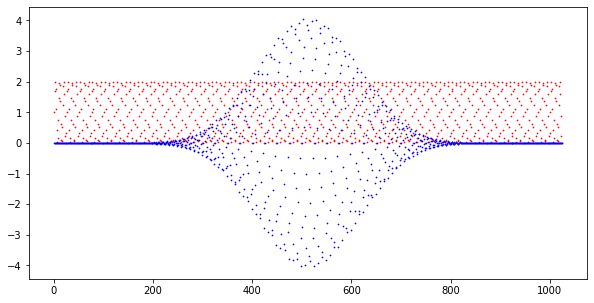

In [13]:
# tbt.window_mean           -- return window weighted mean
# tbt.window_remove_mean    -- copy data to work with removed window weighted mean
# tbt.window_apply          -- apply window to work

# Set window
device = 'cpu'
w = Window.from_cosine(1024, 5.0, dtype=torch.float64, device=device)
print(w)

# Set tbt
d = Data.from_data(w, torch.stack([1.0 + torch.sin(2.0*numpy.pi*0.12*torch.linspace(0, 1024-1, 1024, dtype=w.dtype, device=w.device))]))
print(d)

# Compute mean values
print(torch.mean(d.data, -1))
print(*d.window_mean())

# Remove mean
d.window_remove_mean()
print(*torch.round(d.window_mean()))

# Apply window (change work)
d.window_apply()

# Plot 
t = torch.linspace(1, 1024, 1024, dtype=w.dtype, device=w.device)
plt.figure(figsize=(10, 5))
plt.scatter(t, d.data[0].detach().cpu(), c='r', s=0.5)
plt.scatter(t, d.work[0].detach().cpu(), c='b', s=0.5)
plt.show()

# Clean
del w
del d
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-13: TbT data normalization

Window(1024, 'cosine_window', 5.0)
Data(1, Window(1024, 'cosine_window', 5.0))
tensor([0.], dtype=torch.float64)
tensor(1.000000000000e+00, dtype=torch.float64)


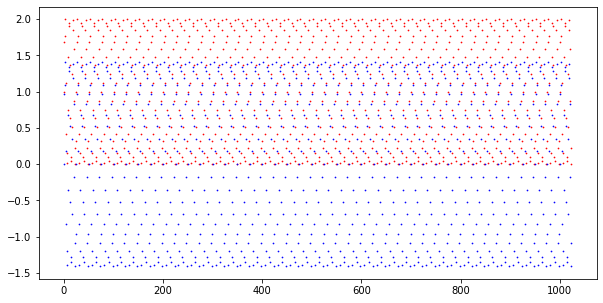

In [14]:
# Set window
device = 'cpu'
w = Window.from_cosine(1024, 5.0, dtype=torch.float64, device=device)
print(w)

# Set TbT
d = Data.from_data(w, torch.stack([1.0 + torch.sin(2.0*numpy.pi*0.12*torch.linspace(0, 1024-1, 1024, dtype=w.dtype, device=w.device))]))
print(d)

# Normalize (change work)
# If window flag is True, window weighted mean is subtracted
d.normalize(window=True)
print(*torch.round(d.window_mean()))
print(torch.std(d.work))

# Plot 
t = torch.linspace(0, w.length-1, w.length, dtype=torch.float64, device=w.device)
plt.figure(figsize=(10, 5))
plt.scatter(t, d.data[0].detach().cpu(), c='r', s=0.5)
plt.scatter(t, d.work[0].detach().cpu(), c='b', s=0.5)
plt.show()

# Clean
del w
del d
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-14: Convert data (return work)

In [15]:
# Run TEST PVs (softIoc -d virtual_tbt.db)

# Set list of pv names and starting indices
bpm = ['STP0']
pv_list = [pv_make(name, 'x', True) for name in bpm]
pv_rise = [0 for _ in range(len(bpm))]

# Set window
device = 'cpu'
w = Window(4, dtype=torch.float64, device=device)
print(w)

# Generate test data
frequency = 0.123456
t = torch.linspace(0, w.length-1, w.length, dtype=torch.float64, device=w.device)
data = [(10.0 + torch.randn(1))*torch.cos(2.0*numpy.pi*frequency*t) for _ in pv_list]
data = torch.stack(data) + 1.0
data.shape

# Set TbT
d = Data.from_data(w, data)
d.pv_list = pv_list
d.pv_rise = pv_rise
d.source = 'epics'
print(d)

# Convert (print result)
print(d.to_tensor())
print(d.to_numpy())
print(d.to_dict())
print(d.to_frame())

# Clean
del w
del d
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(4, None, None)
Data(1, Window(4, None, None))
tensor([[1.179837703705e+01, 8.709319989193e+00, 1.209502108467e+00, -6.410178963270e+00]],
       dtype=torch.float64)
[[11.79837704  8.70931999  1.20950211 -6.41017896]]
{'H:STP0:DATA:X': array([11.79837704,  8.70931999,  1.20950211, -6.41017896])}
              PV       DATA
0  H:STP0:DATA:X  11.798377
1  H:STP0:DATA:X   8.709320
2  H:STP0:DATA:X   1.209502
3  H:STP0:DATA:X  -6.410179


# Example-15: Set TEST PVs

In [1]:
# Start TEST PVs (softIoc -d virtual_tbt.db)
# Load test TbT data, add orbit/noise/spikes and save to TEST PVs

import epics
import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import LIMIT, LENGTH, pv_make
from harmonica.window import Window
from harmonica.data import Data

import matplotlib.pyplot as plt
from time import sleep

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

# Set window
w = Window(4096, dtype=torch.float64)

# Load test TbT data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Add random mean values (orbit) to work
d.work.add_(torch.rand(54).reshape(-1, 1))

# Add random noise to data
std = 1.0E-6*(50.0 + 150.0*torch.rand(54, dtype=torch.float64))
print(std)
d.add_noise(std)

# Add spikes
# d.work[0, 128].add_(+0.025)
# d.work[5, 256].add_(-0.025)

# Set PV names and starting indices
bpm = ['STP2', 'STP4', 'SRP1', 'SRP2', 'SRP3', 'SRP4', 'SRP5', 'SRP6', 'SRP7', 'SRP8', 'SRP9', 'SIP1', 'SIP2', 'SRP10', 'SRP11', 'SRP12', 'SRP13', 'SRP14', 'SRP15', 'SRP16', 'SRP17', 'SEP5', 'SEP4', 'SEP3', 'SEP1', 'SEP0', 'NEP0', 'NEP1', 'NEP3', 'NEP4', 'NEP5', 'NRP17', 'NRP16', 'NRP15', 'NRP14', 'NRP13', 'NRP12', 'NRP11', 'NRP10', 'NIP3', 'NIP1', 'NRP9', 'NRP8', 'NRP7', 'NRP6', 'NRP5', 'NRP4', 'NRP3', 'NRP2', 'NRP1', 'NTP4', 'NTP2', 'NTP0', 'STP0']
pv_list = [pv_make(name, 'x', True) for name in bpm]
pv_rise = [0 for _ in range(len(bpm))]
d.pv_list = pv_list
d.pv_rise = pv_rise

# Save to epics (note, work is saved, not data)
d.save_epics()

True
tensor([8.107244016756e-05, 1.523795064805e-04, 8.429864478522e-05,
        1.751147241461e-04, 1.543330442183e-04, 1.264321785989e-04,
        6.792794678664e-05, 1.506594049582e-04, 1.121436217692e-04,
        1.890080232738e-04, 6.021893014377e-05, 1.099542626740e-04,
        6.837199963703e-05, 1.211124853862e-04, 7.361075905772e-05,
        6.309760713433e-05, 1.044634859617e-04, 1.623684738454e-04,
        9.473167801187e-05, 1.333405027420e-04, 1.537710489454e-04,
        1.661096331812e-04, 1.700378359976e-04, 7.721892323775e-05,
        8.267986859256e-05, 1.800477183647e-04, 6.735870808663e-05,
        1.134285809061e-04, 5.988474867965e-05, 1.316837366372e-04,
        1.709506990796e-04, 1.681798537666e-04, 1.956602029246e-04,
        1.936947432936e-04, 1.867419728679e-04, 1.563811357160e-04,
        1.882012691988e-04, 1.981213056633e-04, 1.845735303189e-04,
        7.892483810183e-05, 1.976022039067e-04, 5.528896707365e-05,
        1.202488955940e-04, 1.659959831174e